In [16]:
import pandas as pd
import csv
import numpy as np
from pandas import concat
from pandas import Series

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers, Sequential, Model
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
# import the data since I trained the model using colab as suggested

In [3]:
df = train.iloc[1: , :]

In [4]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in df.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,32.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)

In [6]:
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [7]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))


In [11]:
def create_uncompiled_model():
  # define a sequential model
  lstm_model = Sequential()
  lstm_model.add(L.LSTM(20, input_shape=(12, 1), return_sequences=True))
  lstm_model.add(L.LSTM(10, activation='relu', return_sequences=True))
  lstm_model.add(L.LSTM(1, activation='relu'))
  lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
  lstm_model.add(L.Dense(5, kernel_initializer='glorot_normal', activation='relu'))
  lstm_model.add(L.Dense(1))

  return lstm_model

In [13]:

class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mse') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:

def create_model():
    tf.random.set_seed(0)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mse"])  
    return model
  
model = create_model()

In [14]:
# After hyperparameter tuning for batch_size and epochs using Gridsearch, 
# considering the trade-off, we choose 
# epochs = 20 and batch_size =128 

# we train for 20 epochs with and assign the callback
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid), 
                              batch_size = 128,
                              verbose=2, callbacks=[early_stopping])

Epoch 1/20
1551/1551 - 74s - loss: 0.2320 - mse: 1.0616 - val_loss: 0.2189 - val_mse: 0.9462 - 74s/epoch - 48ms/step
Epoch 2/20
1551/1551 - 72s - loss: 0.2221 - mse: 0.9548 - val_loss: 0.2183 - val_mse: 0.9428 - 72s/epoch - 46ms/step
Epoch 3/20
1551/1551 - 74s - loss: 0.2217 - mse: 0.9527 - val_loss: 0.2225 - val_mse: 0.9275 - 74s/epoch - 48ms/step
Epoch 4/20
1551/1551 - 73s - loss: 0.2211 - mse: 0.9488 - val_loss: 0.2190 - val_mse: 0.9205 - 73s/epoch - 47ms/step
Epoch 5/20
1551/1551 - 71s - loss: 0.2209 - mse: 0.9479 - val_loss: 0.2182 - val_mse: 0.9258 - 71s/epoch - 46ms/step
Epoch 6/20
1551/1551 - 72s - loss: 0.2208 - mse: 0.9456 - val_loss: 0.2181 - val_mse: 0.9459 - 72s/epoch - 46ms/step
Epoch 7/20
1551/1551 - 70s - loss: 0.2207 - mse: 0.9470 - val_loss: 0.2181 - val_mse: 0.9371 - 70s/epoch - 45ms/step
Epoch 8/20
1551/1551 - 71s - loss: 0.2207 - mse: 0.9461 - val_loss: 0.2182 - val_mse: 0.9470 - 71s/epoch - 46ms/step
Epoch 9/20
1551/1551 - 70s - loss: 0.2206 - mse: 0.9463 - val_lo

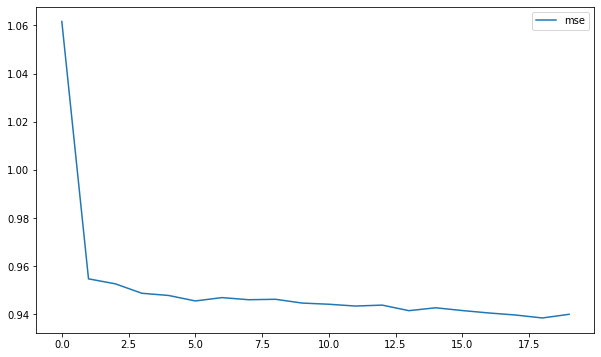

In [19]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mse'], label='mse')
plt.legend()
plt.show()